In [1]:
import tsmd_evaluation.prom as prom

import loconsensus.loconsensus as loconsensus
import stumpy
from distancematrix.ostinato import OstinatoAnytime
from frm import Miner

from experiments.experiment_setup import ExperimentConfig, ExperimentStaticMotif, ExperimentWarpedMotif, ExperimentWarpedVariableLengthMotif

import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
exp = 3
if exp==1:
    config = ExperimentConfig()
    gen = ExperimentStaticMotif(config)
    ts_list, m_pos = gen.generate_experiment()
elif exp==2:
    config = ExperimentConfig(
        m_warping_std=0.5,
        len_std=0.0
    )
    gen = ExperimentWarpedMotif(config)
    ts_list, m_pos = gen.generate_experiment()
elif exp==3:
    config = ExperimentConfig(
        m_warping_std=0.25,
        len_std=25,
    )
    gen = ExperimentWarpedVariableLengthMotif(config)
    ts_list, m_pos = gen.generate_experiment()

153
86
114
91
78
90
134
53
121
79
106


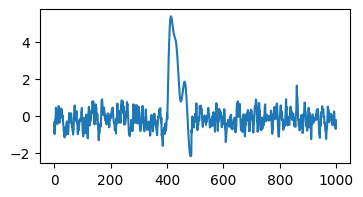

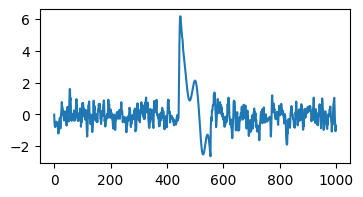

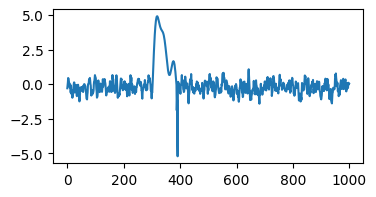

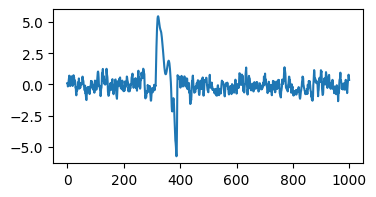

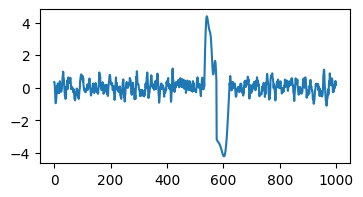

In [3]:
len_base_motif = config.len_base_motif
len_ts = config.len_ts

flat_list = [ts.flatten() for ts in ts_list]

plt.figure(figsize=(4,2))
plt.plot(flat_list[0])
plt.show()
plt.figure(figsize=(4,2))
plt.plot(flat_list[1])
plt.show()
plt.figure(figsize=(4,2))
plt.plot(flat_list[2])
plt.show()
plt.figure(figsize=(4,2))
plt.plot(flat_list[3])
plt.show()
plt.figure(figsize=(4,2))
plt.plot(flat_list[4])
plt.show()

22.74


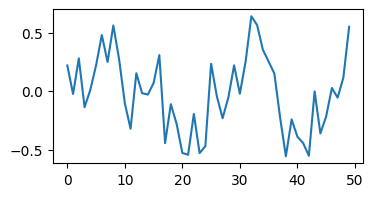

In [4]:
l_min = len_base_motif // 2
l_max = len_base_motif * 2
rho = 0.8 
nb = None

start_time = time.perf_counter()
motifs1 = loconsensus.apply_loconsensus(ts_list, l_min, l_max, rho, nb)
end_time = time.perf_counter() - start_time
print(f'{end_time:.2f}')
plt.figure(figsize=(4,2))
plt.plot(np.concat(ts_list)[motifs1[0][0][0]: motifs1[0][0][1]])
plt.show()

In [5]:
M, _, _ = prom.matching_matrix([m_pos], [motif_set[1] for motif_set in motifs1])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")

[[ 3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  6.]
 [ 0. 11.  5.  3.  4.  4.  4.  3.  2.  3.  2.  2.  4.  2.  2.  3.  3.  2.
   2.  2.  2.  2.  2.  2.  2.  2.  2. nan]]

Micro averaged PROM
Precision: 1.0
Recall: 0.3
F1-score: 0.4615384615384615


28.59


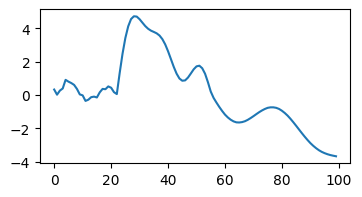

In [6]:
start_time = time.perf_counter()
r, series_idx, subseq_idx = stumpy.ostinato(flat_list, len_base_motif)
cm = flat_list[series_idx][subseq_idx: subseq_idx + len_base_motif]
nn1 = []
for i, ts in enumerate(flat_list):
    ms = np.argmin(stumpy.core.mass(cm, ts))
    nn1.append((ms + i * len_ts, ms + len_base_motif + i * len_ts))
end_time = time.perf_counter() - start_time
print(f'{end_time:.2f}')

plt.figure(figsize=(4,2))
plt.plot(flat_list[series_idx][subseq_idx: subseq_idx+len_base_motif])
plt.show()

In [7]:
M, _, _ = prom.matching_matrix([m_pos], [nn1])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")

[[10.  0.]
 [ 0. nan]]

Micro averaged PROM
Precision: 1.0
Recall: 1.0
F1-score: 1.0


2.60


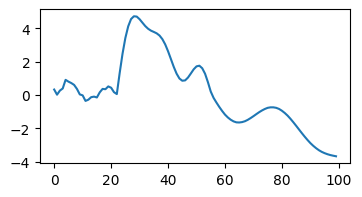

In [8]:
def top1(radii):
    min_dist_per_series = [np.min(radii[i]) for i in range(len(flat_list))]
    min_idx_per_series = [np.argmin(radii[i]) for i in range(len(flat_list))]
    min_idx = np.argmin(min_dist_per_series)
    series_idx = min_idx
    subseq_idx = min_idx_per_series[series_idx]
    return series_idx, subseq_idx

start_time = time.perf_counter()
oa = OstinatoAnytime(flat_list, len_base_motif)
oa.calculate(1.0)
r1 = oa.get_radii()
series_idx, subseq_idx = top1(r1)

cm = flat_list[series_idx][subseq_idx: subseq_idx + len_base_motif]
nn2 = []
for i, _ in enumerate(flat_list):
    ms = np.argmin(r1[i])
    nn2.append((ms + i * len_ts, ms + len_base_motif + i * len_ts))
end_time = time.perf_counter() - start_time
print(f'{end_time:.2f}')

plt.figure(figsize=(4,2))
plt.plot(flat_list[series_idx][subseq_idx:subseq_idx+len_base_motif])

In [9]:
M, _, _ = prom.matching_matrix([m_pos], [nn2])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")

[[ 7.  3.]
 [ 3. nan]]

Micro averaged PROM
Precision: 0.7
Recall: 0.7
F1-score: 0.7


In [10]:
"""
minsup = 0.2
seglen = 5
alfabet = 5
min_len = 2
max_len = 15
K = 5
miner = Miner(minsup, seglen, alfabet, min_len=min_len, k=K)
start_time = time.perf_counter()
motifs2 = miner.mine(flat_list)
end_time = time.perf_counter() - start_time
print(motifs2)
print(f'{end_time:.2f}')

pp = []
for motif in motifs2:
    l = len(motif.representative)
    for k,v in motif.best_matches.items():
        pp.append((v + k * len_ts, v + l + k * len_ts))

print(m_pos)
print(pp)

if len(motifs2) != 0:
    plt.figure(figsize=(4,2))
    plt.plot(motifs2[0].representative)
    plt.show()
"""

"\nminsup = 0.2\nseglen = 5\nalfabet = 5\nmin_len = 2\nmax_len = 15\nK = 5\nminer = Miner(minsup, seglen, alfabet, min_len=min_len, k=K)\nstart_time = time.perf_counter()\nmotifs2 = miner.mine(flat_list)\nend_time = time.perf_counter() - start_time\nprint(motifs2)\nprint(f'{end_time:.2f}')\n\npp = []\nfor motif in motifs2:\n    l = len(motif.representative)\n    for k,v in motif.best_matches.items():\n        pp.append((v + k * len_ts, v + l + k * len_ts))\n\nprint(m_pos)\nprint(pp)\n\nif len(motifs2) != 0:\n    plt.figure(figsize=(4,2))\n    plt.plot(motifs2[0].representative)\n    plt.show()\n"

In [11]:
"""
M, _, _ = prom.matching_matrix([m_pos], [pp])
print(M)
print()
print("Micro averaged PROM")
print(f"Precision: {prom.micro_averaged_precision(M)}")
print(f"Recall: {prom.micro_averaged_recall(M)}")
print(f"F1-score: {prom.micro_averaged_f1(M)}")
"""

'\nM, _, _ = prom.matching_matrix([m_pos], [pp])\nprint(M)\nprint()\nprint("Micro averaged PROM")\nprint(f"Precision: {prom.micro_averaged_precision(M)}")\nprint(f"Recall: {prom.micro_averaged_recall(M)}")\nprint(f"F1-score: {prom.micro_averaged_f1(M)}")\n'